In [1]:
!git clone https://github.com/Kenny3Shen/pytorch-metric-learning.git
!pip install /kaggle/working/pytorch-metric-learning

fatal: destination path 'pytorch-metric-learning' already exists and is not an empty directory.
Processing ./pytorch-metric-learning
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-metric-learning: filename=pytorch_metric_learning-2.5.0-py3-none-any.whl size=119167 sha256=5b057d4e87c94b297a63cb6da884003b12d82943bfc2458317e34604b6d2d9c0
  Stored in directory: /root/.cache/pip/wheels/db/12/24/e0cf2e011070fdf08f09005aca1c43bcafe26549104e2e5d5a
Successfully built pytorch-metric-learning
  Attempting uninstall: pytorch-metric-learning
    Found existing installation: pytorch-metric-learning 2.5.0
    Uninstalling pytorch-metric-learning-2.5.0:
      Successfully uninstalled pytorch-metric-learning-2.5.0


In [2]:
from fastai.vision.all import *
from pytorch_metric_learning import distances, losses, miners, reducers, testers, regularizers, samplers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

DP = True if torch.cuda.device_count() > 1 else False
SAMPLER = False         # 训练集重采样
ATTENTION = False       # use Attention or not
ADD_AP_DISTS = None    # None, max, mean or min
WITHOUT_EMBED = True  # 不使用度量学习
WITHOUT_LOCAL = True   # 不使用局部度量学习

seed = 42
sz = 224 if WITHOUT_LOCAL else 256
bs = 60

<img src="https://github.com/landskape-ai/triplet-attention/raw/master/figures/triplet.png" width="80%">

In [3]:
# Reference
# https://github.com/rwightman/pytorch-image-models/blob/499790e117b2c8c1b57780b73d16c28b84db509e/timm/models/layers/triplet.py
# https://github.com/landskape-ai/triplet-attention/blob/master/MODELS/triplet_attention.py

import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicConv(nn.Module):
    def __init__(
        self,
        in_planes,
        out_planes,
        kernel_size,
        stride=1,
        padding=0,
        dilation=1,
        groups=1,
        relu=True,
        bn=True,
        bias=False,
        act_layer=nn.ReLU,
    ):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(
            in_planes,
            out_planes,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=groups,
            bias=bias,
        )
        self.bn = (
            nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True)
            if bn
            else None
        )
        self.relu = act_layer if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x, inplace=True)
        return x


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat(
            (torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1
        )


class SpatialGate(nn.Module):
    def __init__(self, act_layer=nn.ReLU, kernel_size=7):
        super(SpatialGate, self).__init__()
        self.compress = ChannelPool()
        self.spatial = BasicConv(
            2,
            1,
            kernel_size,
            stride=1,
            padding=(kernel_size - 1) // 2,
            relu=False,
            act_layer=act_layer,
        )

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid_(x_out)
        return x * scale


class TripletAttention(nn.Module):
    def __init__(
        self,
        gate_channels,
        reduction_ratio=16,
        pool_types=["avg", "max"],
        no_spatial=False,
        act_layer=nn.ReLU,
        kernel_size=7,
    ):
        super(TripletAttention, self).__init__()
        self.ChannelGateH = SpatialGate(act_layer=act_layer, kernel_size=kernel_size)
        self.ChannelGateW = SpatialGate(act_layer=act_layer, kernel_size=kernel_size)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate(kernel_size=kernel_size)

    def forward(self, x):
        x_perm1 = x.permute(0, 2, 1, 3).contiguous()
        x_out1 = self.ChannelGateH(x_perm1)
        x_out11 = x_out1.permute(0, 2, 1, 3).contiguous()
        x_perm2 = x.permute(0, 3, 2, 1).contiguous()
        x_out2 = self.ChannelGateW(x_perm2)
        x_out21 = x_out2.permute(0, 3, 2, 1).contiguous()
        if not self.no_spatial:
            x_out = self.SpatialGate(x)
            x_out = (1 / 3) * (x_out + x_out11 + x_out21)
        else:
            x_out = (1 / 2) * (x_out11 + x_out21)
        return x_out

In [4]:
# set_seed 42
set_seed(seed)

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.3, seed=seed),
                 get_y=parent_label,
                 item_tfms=Resize(320),
                 batch_tfms=[*aug_transforms(size=(sz,sz)), Normalize.from_stats(*imagenet_stats)])
loaders = data.dataloaders("/kaggle/input/fvc2000", bs=bs)
# loaders = data.dataloaders("/home/shenss/python/Small-ImageNet-Validation-Dataset-1000-Classes/ILSVRC2012_img_val_subset", bs=120)

In [5]:
classes = len(loaders.vocab)
classes

10

In [6]:
# batch_size must be a multiple of m
# length_before_new_iter >= batch_size must be true
# m * (number of unique labels) >= batch_size must be true
if SAMPLER:
    sampler = samplers.MPerClassSampler(
        loaders.vocab, m=6, batch_size=bs, length_before_new_iter=loaders.train.n
    )
    # Fastai 会自动创建一个新的数据加载器，该数据加载器使用相同的数据集，但使用您传递的修改后的关键字参数。
    loaders.train = loaders.train.new(shuffle=False, sampler=sampler)

In [7]:
#GeM Pooling可以看作Average Pooling和Max Pooling的延申
#当p=1时，GeM Pooling退化成Average Pooling
#当p无穷大时，GeM pooling 等效于Max Pooling
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps
    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

class CustomModel(nn.Module):
    def __init__(self, encoder, head, attention=False):
        super().__init__()
        self.encoder = encoder
        self.head = head
        self.avgpool = AdaptiveAvgPool((1, 1))
        self.conv1_1 = nn.Conv2d(2048, 256, 1)
        self.GeM = GeM()
        self.attention = attention
        if self.attention:
            self.attention_block = TripletAttention(2048)
    def VPB(self, x):
        x = torch.chunk(x, 4, dim=3)
        x = [self.avgpool(chunk) for chunk in x]
        x = [self.conv1_1(chunk) for chunk in x]
        x = [chunk.view(chunk.size(0), -1) for chunk in x]
        x = torch.cat(x, dim=1)
        return x
    def HPB(self, x):
        x = torch.chunk(x, 4, dim=2)
        x = [self.avgpool(chunk) for chunk in x]
        x = [self.conv1_1(chunk) for chunk in x]
        x = [chunk.view(chunk.size(0), -1) for chunk in x]
        x = torch.cat(x, dim=1)
        return x
    def GPB(self, x):
        x = self.GeM(x)
        x = x.view(x.size(0), -1)
        return x
    def forward(self, x):
        x = self.encoder(x)
        if self.attention:
            x = self.attention_block(x)
        horizontal_embeddings = self.HPB(x)
        vertical_embeddings = self.VPB(x)
        global_embeddings = self.GPB(x)
        classification = self.head(global_embeddings)
        return horizontal_embeddings, vertical_embeddings, global_embeddings, classification

backbone=resnet50(weights="DEFAULT")
if not WITHOUT_LOCAL:
    backbone.layer4[0].conv2.stride = (1, 1)
    backbone.layer4[0].downsample[0].stride = (1, 1)
encoder = create_body(backbone)
head = nn.Sequential(
    #nn.BatchNorm1d(2048),
    nn.Linear(in_features=2048, out_features=classes, bias=True)
)
#head = create_head(2048, classes, [512, 64], 0.5)
#apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head, attention=ATTENTION)) if DP else CustomModel(encoder, head, attention=ATTENTION)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

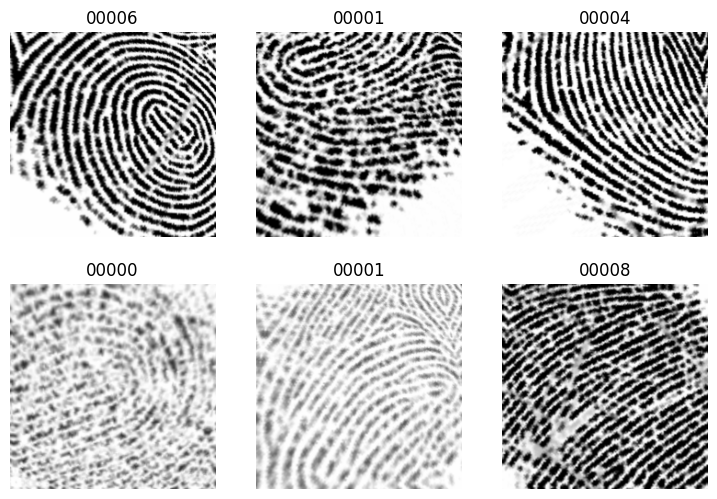

In [8]:
loaders.train.show_batch(max_n=6, nrows=2)

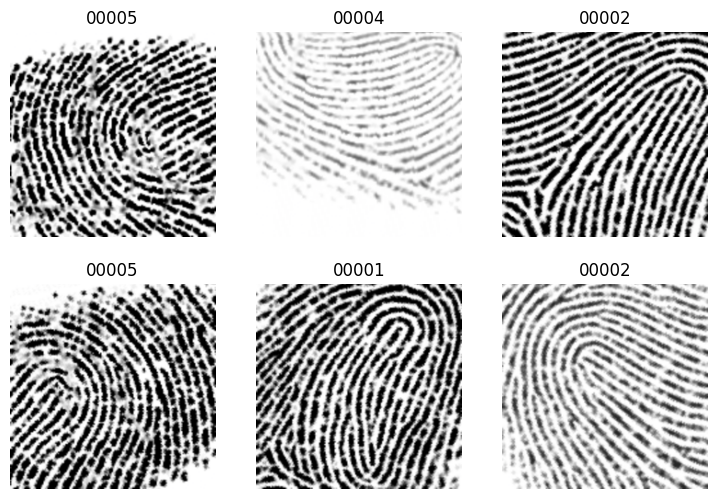

In [9]:
loaders.valid.show_batch(max_n=6, nrows=2)

In [10]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0.1, high=0.9)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
#mining_func = miners.BatchHardMiner(distance=distance)
classification_loss = torch.nn.CrossEntropyLoss()

# def mined_loss(miner, loss_func):
#     def loss(embeddings, labels):
#         mined = miner(embeddings, labels)
#         return loss_func(embeddings, labels, mined)
#     return loss

# my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class MinedLoss(nn.Module):
    def __init__(self, miner, loss_func, add_ap_dists=None):
        super().__init__()
        self.miner = miner
        self.loss_func = loss_func
        self.add_ap_dists = add_ap_dists
    def forward(self, embeddings, labels):
        mined = self.miner(embeddings, labels)
        embedding_loss = self.loss_func(embeddings, labels, mined)
        ap_dists = self.loss_func.ap_dists
        #print(f"AP Dist {self.add_ap_dists}: ", torch.mean(ap_dists))
        if self.add_ap_dists == 'mean':
            return embedding_loss + torch.mean(ap_dists)
        elif self.add_ap_dists == 'max':
            return embedding_loss + torch.max(ap_dists)
        elif self.add_ap_dists == 'min':
            return embedding_loss + torch.min(ap_dists)
        else:
            return embedding_loss

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, without_embed=False, without_local=False):
        super().__init__()
        self.hor_emb_loss = embed_loss_func
        self.ver_emb_loss = embed_loss_func
        self.glob_emb_loss = embed_loss_func
        self.class_loss_func = class_loss_func
        self.without_embed = without_embed
        self.without_local = without_local
    def forward(self, preds, target):
        #embeddings, classifications = preds
        horizontal_embeddings, vertical_embeddings, global_embeddings, classifications = preds

        horizontal_loss = self.hor_emb_loss(horizontal_embeddings, target)
        vertical_loss = self.ver_emb_loss(vertical_embeddings, target)
        global_loss = self.glob_emb_loss(global_embeddings, target)
        
        class_loss = self.class_loss_func(classifications, target)
        if self.without_embed:
            return class_loss
        elif self.without_local:
            return global_loss + class_loss
        else:
            return horizontal_loss + vertical_loss + global_loss + class_loss
        
embedding_loss = MinedLoss(mining_func, loss_func, add_ap_dists=ADD_AP_DISTS)
combined_loss = CombinedLoss(embedding_loss, classification_loss, without_embed=WITHOUT_EMBED, without_local=WITHOUT_LOCAL)

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback, SaveModelCallback (monitor='f1score')],
              metrics=[accuracy,precision,recall,f1score])

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,2.381197,2.346041,0.175000,0.319465,0.176528,0.143790,00:05
1,2.315948,2.260402,0.179167,0.250828,0.184058,0.150770,00:04
2,2.193459,2.040578,0.262500,0.308970,0.269315,0.214890,00:04
3,2.027445,1.775732,0.433333,0.480727,0.452989,0.397358,00:04
4,1.849651,1.440065,0.562500,0.669410,0.582168,0.537211,00:04
5,1.662611,1.102370,0.637500,0.679946,0.657758,0.585235,00:04
6,1.497178,0.807651,0.741667,0.752944,0.753655,0.720096,00:04
7,1.346204,0.691217,0.766667,0.800034,0.786328,0.753609,00:04
8,1.205418,0.647979,0.795833,0.840481,0.813609,0.787509,00:04
9,1.085715,0.504807,0.833333,0.846762,0.833322,0.820132,00:04


Better model found at epoch 0 with f1score value: 0.1437898869388639.


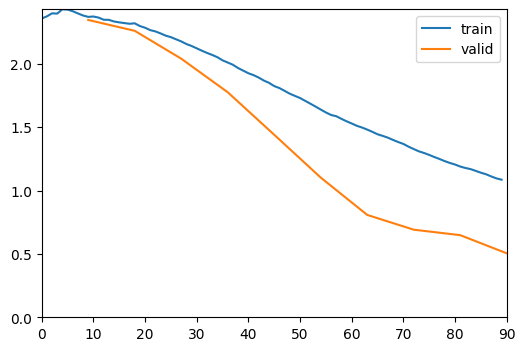

Better model found at epoch 1 with f1score value: 0.15077033969642326.
Better model found at epoch 2 with f1score value: 0.2148904012654013.
Better model found at epoch 3 with f1score value: 0.397358034981874.
Better model found at epoch 4 with f1score value: 0.5372107623628521.
Better model found at epoch 5 with f1score value: 0.5852349039849041.
Better model found at epoch 6 with f1score value: 0.7200958922398552.
Better model found at epoch 7 with f1score value: 0.7536094297859003.
Better model found at epoch 8 with f1score value: 0.7875086280678386.
Better model found at epoch 9 with f1score value: 0.8201317101800848.


epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,0.481825,0.465042,0.858333,0.872874,0.867537,0.850546,00:05
1,0.494540,0.421189,0.866667,0.863132,0.859658,0.847543,00:05
2,0.496034,0.428464,0.887500,0.887262,0.903370,0.882131,00:05
3,0.483531,0.418698,0.891667,0.887639,0.903231,0.879926,00:05
4,0.463775,0.394021,0.883333,0.867538,0.873181,0.862201,00:05
5,0.459057,0.381375,0.895833,0.903312,0.912259,0.896419,00:05
6,0.450127,0.322550,0.908333,0.897983,0.899271,0.890222,00:05
7,0.435067,0.328601,0.916667,0.913341,0.929881,0.908058,00:05
8,0.422475,0.297468,0.912500,0.903105,0.923164,0.903095,00:05
9,0.408524,0.314928,0.912500,0.915611,0.930803,0.909207,00:05


Better model found at epoch 0 with f1score value: 0.8505461454983598.


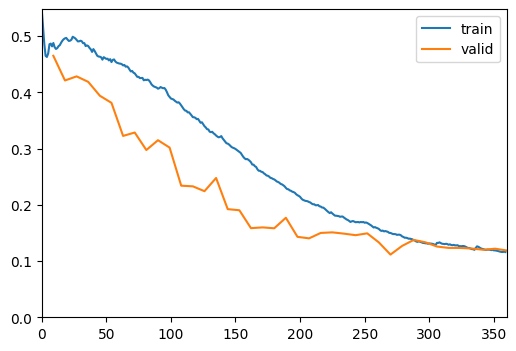

Better model found at epoch 2 with f1score value: 0.8821310184913126.
Better model found at epoch 5 with f1score value: 0.8964189078894961.
Better model found at epoch 7 with f1score value: 0.9080578350901577.
Better model found at epoch 9 with f1score value: 0.9092070550222723.
Better model found at epoch 11 with f1score value: 0.9370495356466719.
Better model found at epoch 15 with f1score value: 0.9427110196305243.
Better model found at epoch 17 with f1score value: 0.9517249453762611.
Better model found at epoch 19 with f1score value: 0.9598499453762611.
Better model found at epoch 22 with f1score value: 0.9625411931120136.
Better model found at epoch 29 with f1score value: 0.9783208020050125.


In [12]:
learn.fine_tune(40,freeze_epochs=10)

In [13]:
# Baseline: Resnet50 + CE_loss--0.975000	0.982302	0.976052	0.978321

In [14]:
hooks = Hooks(model.module.encoder if DP else model.encoder, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    hooks_output = nn.Flatten()(hooks.stored[-1])
    hooks_output = hooks_output.to(ftrs.device)  # move hooks_output to the same device as ftrs
    ftrs = torch.cat((ftrs, hooks_output))

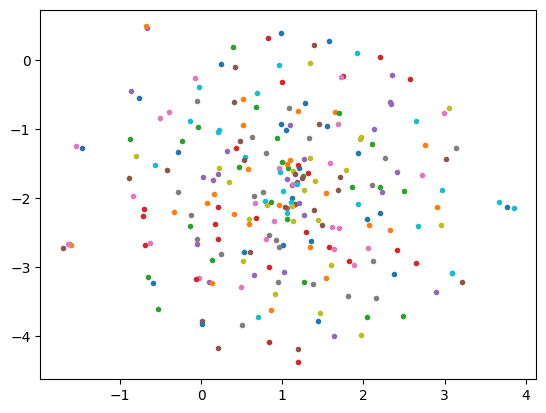

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')